##### Copyright 2022 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Qubit Picking

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/hardware/qubit_picking"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/hardware/qubit_picking.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/hardware/qubit_picking.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/hardware/qubit_picking.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

When running a circuit on a noisy quantum hardware device, the choice and even ordering of hardware qubits used directly affects how reliably the device measures a correct result. This notebook covers some of the available qubit error information that can be useful for picking good hardware qubits to run your circuit on.

## Setup

Note: this notebook relies on unreleased Cirq features. If you want to try these features, make sure you install cirq via `pip install --upgrade cirq~=1.0.dev`.

In [2]:
# @title Setup
try:
    import cirq

    # raise ImportError when cirq is not new enough
    if cirq.__version__ == "1.5.0":
        raise ImportError("This notebook requires the development version of Cirq")
except ImportError:
    print("installing cirq...")
    !pip install --upgrade --quiet cirq~=1.0.dev
    print("installed cirq.")
    import cirq

import cirq_google
import numpy as np
from matplotlib import pyplot as plt

installing cirq...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf<4.22,>=4.21.6; python_version < "3.11", but you have protobuf 5.29.5 which is incompatible.


installed cirq.


## State of qubit selection in Cirq

Cirq assumes that circuits you intend to run on quantum hardware (virtual or otherwise) are able to be placed on the device, and assumes that you are able to perform placement by hand. The information in this notebook serves to help you identify which qubits are the best to use, but it is up to you to map the qubits in your circuit to the "good" qubits available on the device.

## Error characterization data

Cirq provides characterization error data that is intended to represent median performance of actual Google quantum hardware as accurately as possible. The primary use of this data is for creating a `cirq.NoiseModel` for use in a [Quantum Virtual Machine](../simulate/quantum_virtual_machine.ipynb), but it also provides information on what qubits are the best to use for your circuit. 

The following code demonstrates how to load that noise data as a `cirq_google.GoogleNoiseProperties` object, which specifies the available data.

In [3]:
processor_id = "rainbow"
noise_props = cirq_google.engine.load_device_noise_properties(processor_id)

### One qubit gate Pauli error data

Pauli error defines decoherence of a single qubit in one of the Pauli [channels](../noise/representing_noise.ipynb) X, Y, or Z. If the errors are distributed in the uniform distribution over all three axes, the probability of applying an erroneous Pauli gate X, Y, or Z will be the Pauli error divided by three. See page 11 of [this Supplementary Information document](https://arxiv.org/abs/1910.11333){:.external} for more on Pauli error. 

Below is the single qubit Pauli error for the `cirq.PhasedXZGate` supported by the Rainbow processor, pulled from the `gate_pauli_errors` attribute of the noise properties object. You can inspect the error for the other supported one-qubit gates by replacing the `gate` variable below. However, as of July 19th, 2022, the error estimation process results in identical Pauli error for all one-qubit gates.

One qubit error data: gate_pauli_errors
Supported Gates: {<class 'cirq.ops.measurement_gate.MeasurementGate'>, <class 'cirq.ops.phased_x_z_gate.PhasedXZGate'>, <class 'cirq.ops.common_gates.ZPowGate'>, <class 'cirq.ops.common_channels.ResetChannel'>}


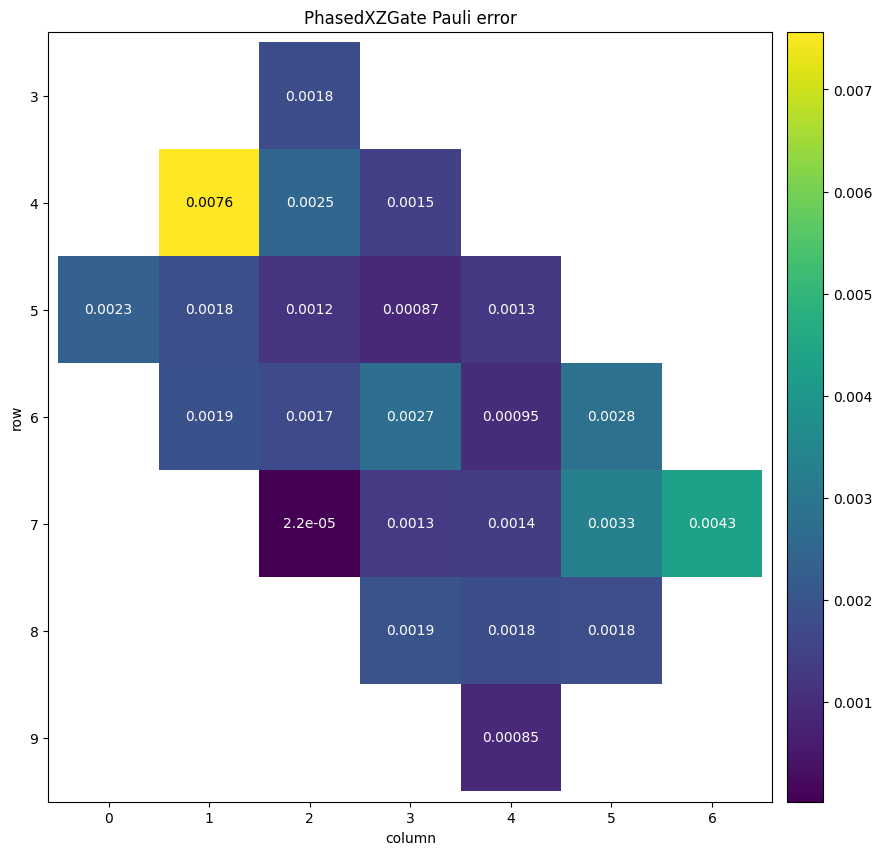

In [4]:
print(f"One qubit error data: gate_pauli_errors")
print(f"Supported Gates: {noise_props.single_qubit_gates()}")
fig, ax = plt.subplots(figsize=(10, 10))
gate = cirq.PhasedXZGate
measures = {
    op_id.qubits: pauli_error
    for op_id, pauli_error in noise_props.gate_pauli_errors.items()
    if op_id.gate_type == gate
}
ax.set_title(f"{gate.__name__} Pauli error")
_ = cirq.Heatmap(measures).plot(ax)
fig.show()

The provided error data shows identical Pauli error for all gate types, with relatively higher error for qubits `(4,1)` and `(7,6)`. Qubit `(7,2)` is noticeably lower error than the others, and could be prioritized to be mapped to a circuit qubit that executes many single-qubit operations. However, this is only one type of error; you should inspect the other error types before committing to use any particular qubits.

### Two qubit gate Pauli error data

The two qubit gates also cause Pauli decoherence, which is also stored in the `gate_pauli_errors` attribute. 

Two qubit error data: gate_pauli_errors


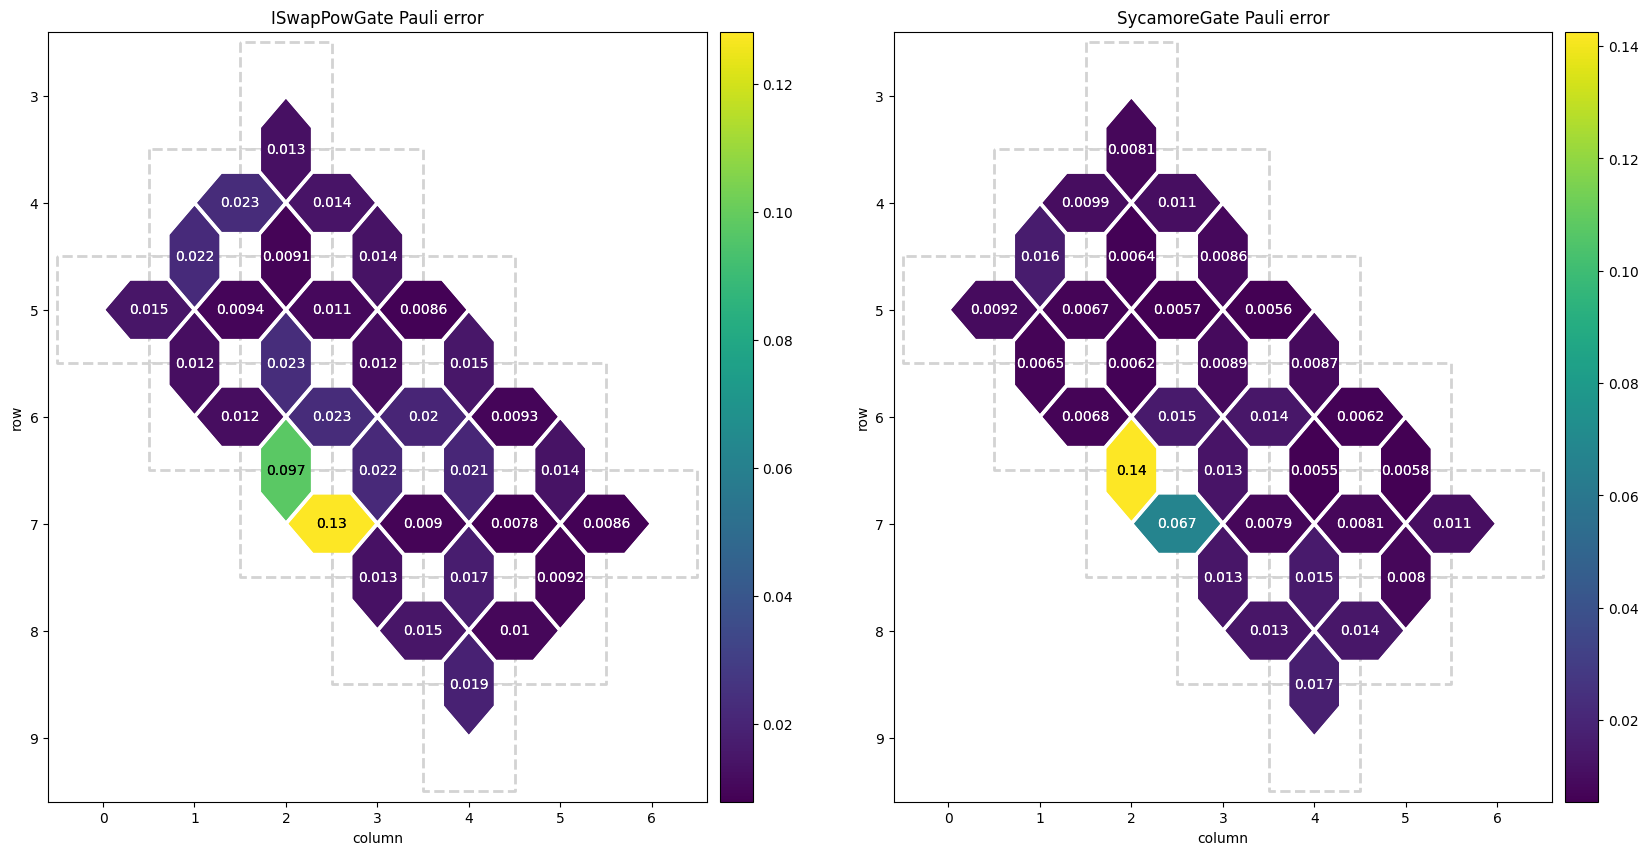

In [5]:
two_qubit_gates = noise_props.two_qubit_gates()
print(f"Two qubit error data: gate_pauli_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: pauli_error
        for op_id, pauli_error in noise_props.gate_pauli_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        ax.set_title(f"{gate.__name__} Pauli error")
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)

fig.show()

This Pauli data informs that the qubit pairs `(6,2)-(7,2)` and `(7,2)-(7,3)` should be avoided at all costs, but the other qubits are roughly comparable.

### Two qubit gate FSim error

FSim error represents [coherent](../noise/representing_noise.ipynb#channels) two-qubit error that cannot be represented by Pauli channels (that is, it results from entanglement). Instead, it is represented as an additional `cirq.PhasedFSimGate` with small parameters that would be applied to a given qubit pair after any two-qubit gate's execution.

The following example takes the norm of a couple of the parameters, as a rough approximate representation of the goodness of qubit pairs relative to one another. 

In [6]:
print(f"Two qubit error data: fsim_errors")
two_qubit_gates = noise_props.two_qubit_gates()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: fsim_refit_gate
        for op_id, fsim_refit_gate in noise_props.fsim_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        # Norm the Fsim refit gate parameters as an approximate of how good a qubit is.
        measures = {
            qubits: np.linalg.norm([fsim_refit_gate.theta, fsim_refit_gate.phi])
            for qubits, fsim_refit_gate in measures.items()
        }
        ax.set_title(f"{gate.__name__} Pauli error")
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)

fig.show()

Two qubit error data: fsim_errors


This fsim data would influence you to avoid the `(6,2)-(7,2)` qubit pair, and prefer the top left of the grid for high-priority qubit pairs  (those that have two-qubit gates executed on them many times in your circuit). Additionally, the fact that the `cirq.SycamoreGate` error is so much lower than the `cirq.ISwapPowGate` error means the device was likely calibrated for the `SycamoreGate`, and you should [transform](../transform/transformers.ipynb) your circuit with `cirq.optimize_for_target_gateset` to the `cirq_google.transformers.SycamoreTargetGateset` gate set, if possible.

This particular type of error can be compensated for somewhat, by using [Floquet calibration](../noise/floquet_calibration_example.ipynb), but this is out of scope for this notebook, and may require adaptation to work with the provided processor error data.

### Readout error

Readout error manifests as a measurement of $|0\rangle$ that should have been $|1\rangle$, or vice versa. Note that this is different from the Pauli error induced by the `cirq.MeasurementGate`. It's important to note that, while the magnitude of measurement error is higher in general than that of Pauli error, it should be not automatically be considered to be more impactful. This is due to the fact that Pauli error can affect qubits other than the measured one and that effective readout error compensation strategies exist (that won't be discussed here).

One qubit error data: readout_errors


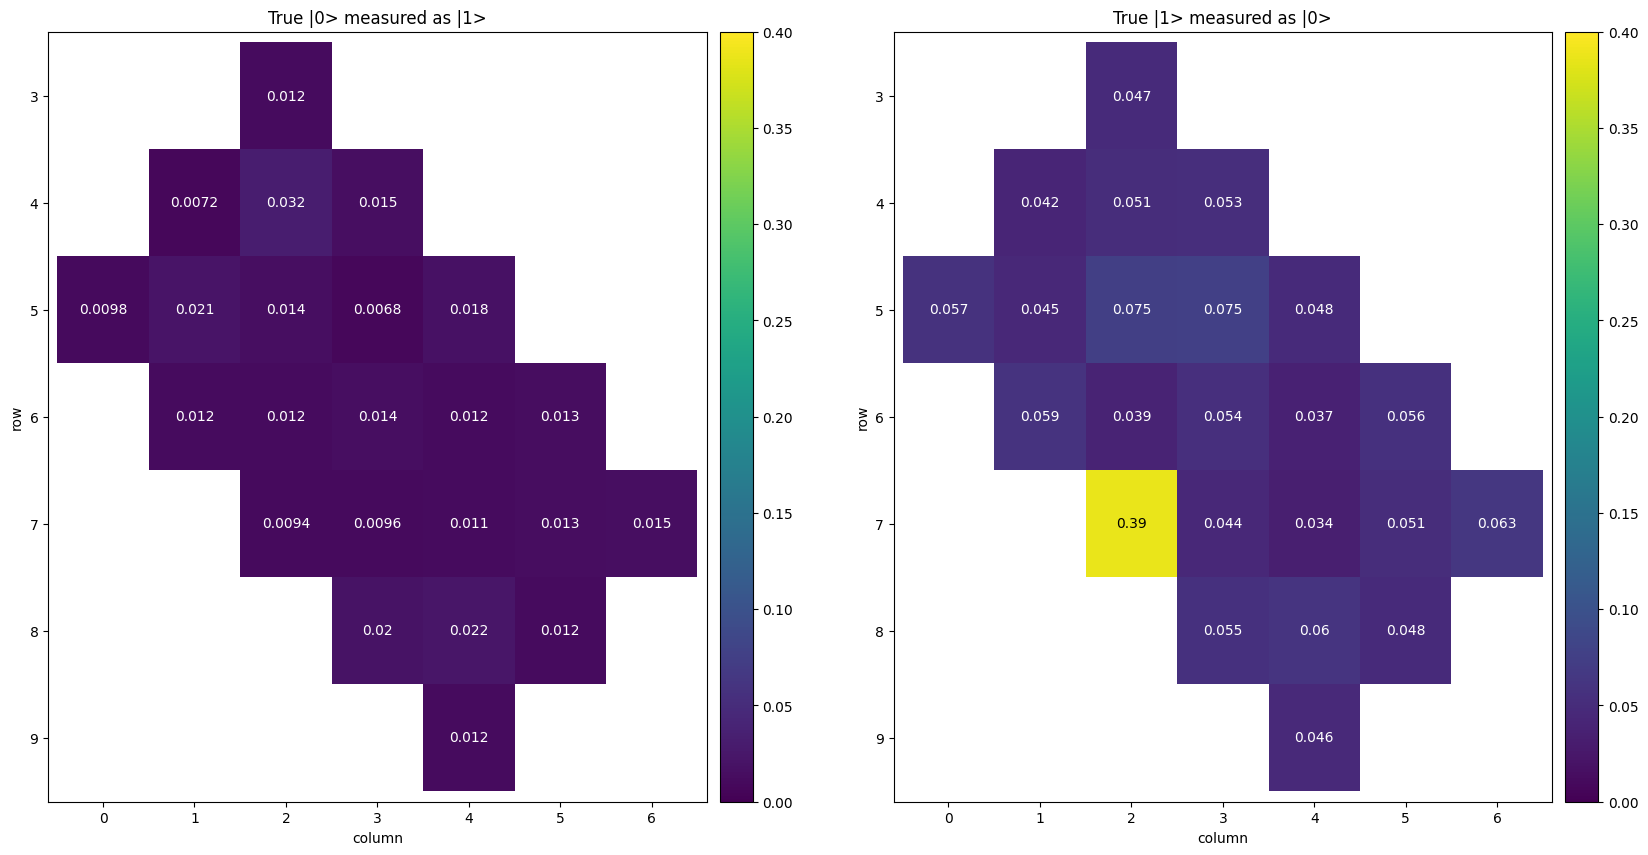

In [7]:
print(f"One qubit error data: readout_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, ax, title in zip(
    range(2), axes.flat, ["True |0> measured as |1>", "True |1> measured as |0>"]
):
    measures = {
        qubit: readout_error[i] for qubit, readout_error in noise_props.readout_errors.items()
    }
    ax.set_title(title)
    _ = cirq.Heatmap(measures).plot(ax, vmax=0.4, vmin=0)
fig.show()

This readout data indicates that you definitely want to avoid qubit `(7,2)`. If you're really trying to eke out the best performance possible, you may want to avoid qubits `(5,2)` and `(5,3)` as well. Note how the "True $|1\rangle$ measured as $|0\rangle$" error representing common decay is far larger and more impactful than the random excitation of $|0\rangle$ to $|1\rangle$ error. This is typical behavior and you can safely prioritize working around common decay error instead of random excitation error in most cases.

## Overall qubit picking strategy

Even though the single Pauli qubit data preferred qubit `(7,2)`, the coupled pairs attached to that qubit have abysmal error rates, meaning it should be avoided at all costs. Qubit `(4,1)` has some interesting properties in that its two-qubit gates are quite good, and so is its readout, but not its single-qubit Pauli error. It may be useful to use this qubit in an entangled system where only the other qubits have single-qubit gates applied to them. All of the other gates are roughly comparable based on these error rates. Ultimately, the choice of which hardware qubits have which circuit operations applied to them is up to your discretion.

# Summary

Cirq provides the following error types which serve to represent an actual Google quantum hardware device as accurately as currently possible: 
- One- and two-qubit Pauli error for each `cirq.Gate` supported by the device
- Two-qubit Fsim error for each supported two-qubit gate that models non-Pauli error. 
- Readout error for each qubit that models error in measurements.

While often used to create [QVM](../simulate/quantum_virtual_machine.ipynb)s, this data is also useful in the process of finding good qubits to use. By avoiding high error qubits whenever possible, you can maximize the reliability of your circuit. 

If you're working with an actual device that may experience drift, or a change in behavior over time, you may need to use more advanced noise compensation strategies, which you can read about in the [Noise](../noise) category.